# Comparison of GeoPandas and PostGIS

The postgis examples are taken from the tutorial of Boundless (http://workshops.boundlessgeo.com/postgis-intro/, CC BY SA), the used data can be downloaded from there.

**DISCLAIMER**: this is just a dummy comparison and no real performance benchmark, and I am not a PostGIS expert.

Data are loaded into postgresql database:

```
shp2pgsql -s 26918 nyc_census_blocks.shp public.nyc_census_blocks | psql -h localhost -d postgres -U postgres
shp2pgsql -s 26918 nyc_streets.shp public.nyc_streets | psql -h localhost -d postgres -U postgres
shp2pgsql -s 26918 nyc_neighborhoods.shp public.nyc_neighborhoods | psql -h localhost -d postgres -U postgres
shp2pgsql -s 26918 nyc_subway_stations.shp public.nyc_subway_stations | psql -h localhost -d postgres -U postgres
shp2pgsql -s 26918 nyc_homicides.shp public.nyc_homicides | psql -h localhost -d postgres -U postgres
```

In [3]:
%matplotlib inline

import matplotlib.pyplot as plt
import geopandas

from shapely.geometry import Point

In [4]:
nyc_census_blocks = geopandas.read_file("../../postgis-workshop/data/nyc_census_blocks.shp")
nyc_streets = geopandas.read_file("../../postgis-workshop/data/nyc_streets.shp")
nyc_neighborhoods = geopandas.read_file("../../postgis-workshop/data/nyc_neighborhoods.shp")
nyc_subway_stations = geopandas.read_file("../../postgis-workshop/data/nyc_subway_stations.shp")
nyc_homicides = geopandas.read_file("../../postgis-workshop/data/nyc_homicides.shp")

## Distance example

Example from http://workshops.boundlessgeo.com/postgis-intro/spatial_relationships_exercises.html

```sql
-- Approximately how many people live on (within 50 meters of) Atlantic Commons?

SELECT Sum(popn_total)
FROM nyc_census_blocks
WHERE ST_DWithin(
   geom,
   ST_GeomFromText('POINT(586782 4504202)', 26918),
   50
);
```

The problem with this example is that we don't have a 'dwithin' method in shapely/geopandas. Therefore I slightly adjusted this example (although this is slower in postgis, but more comparable to the geopandas version):

```sql
SELECT Sum(popn_total)
FROM nyc_census_blocks
WHERE ST_Distance(
   geom,
   ST_GeomFromText('POINT(586782 4504202)', 26918)) < 50
;
```

Some timings of the above query with postgis:

In [12]:
t_dist_postgis = np.mean([68, 78, 109, 76, 67, 54, 83])

Now the same with geopandas:

In [7]:
subset = nyc_census_blocks[nyc_census_blocks.distance(Point(586782, 4504202)) < 50]
subset['POPN_TOTAL'].sum()

896

This gives the same result as the postgis query.

Timings:

In [10]:
%%timeit
subset = nyc_census_blocks[nyc_census_blocks.distance(Point(586782, 4504202)) < 50]
subset['POPN_TOTAL'].sum()

419 ms ± 10.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [13]:
t_dist_cython = np.mean([108, 113, 109])

In [11]:
t_dist_geopandas = np.mean([415, 425, 419])

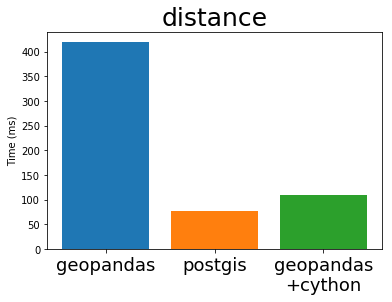

In [62]:
fig, ax = plt.subplots()
ax.bar([0,1,2], [t_dist_geopandas, t_dist_postgis, t_dist_cython], color=['C0', 'C1', 'C2'])
ax.set_xticks([0, 1, 2])
ax.set_xticklabels(['geopandas', 'postgis', 'geopandas\n+cython'], fontsize=18)
ax.set_title('distance', fontsize=25)
ax.set_ylabel('Time (ms)');
fig.savefig("img/timings_distance2_all.png", bbox_inches='tight')

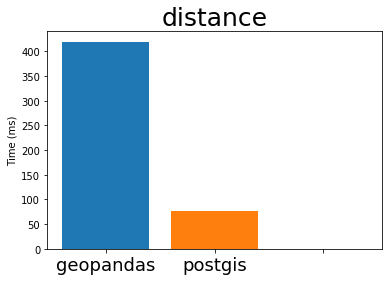

In [63]:
fig, ax = plt.subplots()
ax.bar([0,1,2], [t_dist_geopandas, t_dist_postgis, 0], color=['C0', 'C1', 'C2'])
ax.set_xticks([0, 1, 2])
ax.set_xticklabels(['geopandas', 'postgis', ' \n '], fontsize=18)
ax.set_title('distance', fontsize=25)
ax.set_ylabel('Time (ms)');
fig.savefig("img/timings_distance2.png", bbox_inches='tight')

## Spatial joins

Example from http://workshops.boundlessgeo.com/postgis-intro/joins.html

```sql
CREATE INDEX nyc_census_blocks_geom_gist ON nyc_census_blocks USING GIST (geom);
CREATE INDEX nyc_neighborhoods_geom_gist ON nyc_neighborhoods USING GIST (geom);
```

```sql
-- What is the population and racial make-up of the neighborhoods 
-- of Manhattan?
SELECT
  neighborhoods.name AS neighborhood_name,
  Sum(census.popn_total) AS population,
  100.0 * Sum(census.popn_white) / NULLIF(Sum(census.popn_total),0) AS white_pct,
  100.0 * Sum(census.popn_black) / NULLIF(Sum(census.popn_total),0) AS black_pct
FROM nyc_neighborhoods AS neighborhoods
JOIN nyc_census_blocks AS census
ON ST_Intersects(neighborhoods.geom, census.geom)
GROUP BY neighborhoods.name
ORDER BY white_pct DESC;
```


Timing: 553 ms

In [32]:
t_sjoin_postgis = 553

Now the same in geopandas:

In [27]:
res = geopandas.sjoin(nyc_neighborhoods, nyc_census_blocks, op='intersects')
res= res.groupby('NAME')[['POPN_TOTAL', 'POPN_WHITE', 'POPN_BLACK']].sum()
res['POPN_BLACK'] = res['POPN_BLACK'] / res['POPN_TOTAL'] * 100
res['POPN_WHITE'] = res['POPN_WHITE'] / res['POPN_TOTAL'] * 100
res.sort_values('POPN_WHITE', ascending=False)

,POPN_TOTAL,POPN_WHITE,POPN_BLACK
NAME,,,
Huguenot,11238,93.691048,0.400427
Prince's Bay,9974,93.613395,0.862242
Tottensville,15172,93.323227,0.599789
Great Kills,19131,93.084523,0.622027
Ettingville,35553,92.875425,0.537226
Annandale,13695,92.771084,0.306681
Woodrow,10408,92.409685,0.941583
Carnegie Hill,18763,90.081543,1.412354
Oakwood,30644,89.227908,1.585955


In [28]:
%%timeit
res = geopandas.sjoin(nyc_neighborhoods, nyc_census_blocks, op='intersects')
res= res.groupby('NAME')[['POPN_TOTAL', 'POPN_WHITE', 'POPN_BLACK']].sum()
res['POPN_BLACK'] = res['POPN_BLACK'] / res['POPN_TOTAL'] * 100
res['POPN_WHITE'] = res['POPN_WHITE'] / res['POPN_TOTAL'] * 100
res.sort_values('POPN_WHITE', ascending=False)

3.66 s ± 66 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [34]:
t_sjoin_cython = 538

In [35]:
t_sjoin_geopandas = 3660

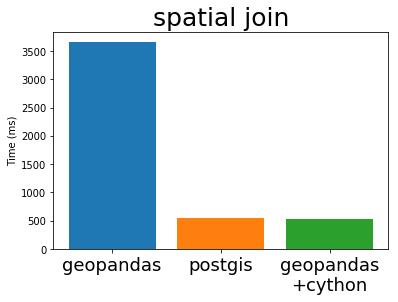

In [59]:
fig, ax = plt.subplots()
ax.bar([0,1,2], [t_sjoin_geopandas, t_sjoin_postgis, t_sjoin_cython], color=['C0', 'C1', 'C2'])
ax.set_xticks([0, 1, 2])
ax.set_xticklabels(['geopandas', 'postgis', 'geopandas\n+cython'], fontsize=18)
ax.set_title('spatial join', fontsize=25)
ax.set_ylabel('Time (ms)');
fig.savefig("img/timings_sjoin_all.png", bbox_inches='tight')

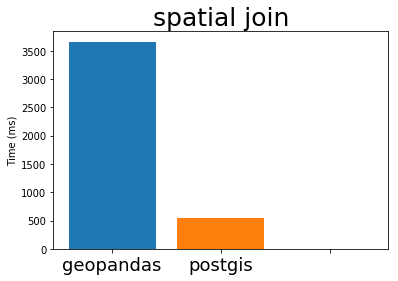

In [61]:
fig, ax = plt.subplots()
ax.bar([0,1,2], [t_sjoin_geopandas, t_sjoin_postgis, 0], color=['C0', 'C1', 'C2'])
ax.set_xticks([0, 1, 2])
ax.set_xticklabels(['geopandas', 'postgis', ' \n '], fontsize=18)
ax.set_title('spatial join', fontsize=25)
ax.set_ylabel('Time (ms)');
fig.savefig("img/timings_sjoin.png", bbox_inches='tight')